In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import math as m
import random
import ContextBandit as cb
import SimKNN
from pathos.multiprocessing import ProcessingPool as Pool

In [4]:
def uncertainty(k, actions, rewards, distances,theta,phi, a):
    t = len(actions)
    k_least = np.argpartition(distances, k - 1)[:k]
    N = sum(np.array(actions)[k_least] == a)
    U = m.sqrt(theta * m.log(t) / N) + phi(t) * distances[k_least[-1]] if (N != 0) else m.inf
    return U
    
def k_ternary_search(actions, rewards, distances, theta, phi, a):
    f = lambda k : uncertainty(k, actions,rewards,distances,theta,phi, a)
    t = len(actions) - 1
    l = 1
    r = t
    while(True):
        c1 = l + m.floor((r - l)/ 3)
        c2 = l + 2 * m.floor((r-l)/3)
        if f(c1) > f(c2):
            l = c1
        elif f(c1)< f(c2):
            r = c2
        else:
            if c1 == c2:
                return c1
            else:
                l,r = c1,c2
        if abs(l-r) <= 1:
            break
    return m.floor((l+r)/2)
        


In [3]:
def KNN_UCB(bandit,X, theta, phi): ##X:context vector
    n = len(X)
    regrets = []
    n_arms = bandit.k #number of arms
    actions = []
    rewards = []
    assert(n >= n_arms)
    for a in range(n_arms): ##play each arm once regardless of context
        reward = bandit.pull(a, X[a])
        rewards.append(reward)
        actions.append(a)
        regrets.append(bandit.regret)
    for t in range(n_arms,n,1):
        if(t%100 == 0):
            print(t)
        distances= cdist(X[:t], [X[t]], 'Euclidean')
        distances = [dist for sublist in distances for dist in sublist]
        k_a = np.zeros(n_arms)
        index = np.zeros(n_arms) ## to store I_t,k
        for a in range(n_arms): ##evaluate k_a for all a
            k_a[a]= k_ternary_search(actions, rewards, distances, theta, phi, a)
            k_least = np.argpartition(distances, int(k_a[a]-1))[:int(k_a[a])]
            N = sum(np.array(actions)[k_least] == a)
            S = sum(np.array(rewards)[k_least] * (np.array(actions)[k_least] == a))
            f_hat = S/N if (N!=0) else 0
            index[a] = f_hat + m.sqrt(theta* m.log(t)/N) + phi(t) * distances[k_least[-1]] if(N!=0) else m.inf
        arm = np.argmax(index)
        reward = bandit.pull(arm, X[t])
        regrets.append(bandit.regret)
        actions.append(arm)
        rewards.append(reward)
    return actions, rewards, regrets

In [86]:
X = np.random.uniform(0,1, size = (3000,2))
lambdas = [lambda x: np.prod([m.sin(4*xs * m.pi) for xs in x]),
           lambda x: np.prod([m.cos(7*xs * m.pi) for xs in x])]
noise = lambda x : np.random.normal(0,0.5)
bandit = cb.ContextBandit(lambdas, noise)
actions6,rewards6,regrets6= KNN_UCB(bandit,X, 1, lambda a : 25)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [88]:
np.sum(np.subtract(regrets6[1:], regrets6[:-1]) == 0)

1987

In [75]:
regrets = np.loadtxt('regrets1.csv', delimiter=',')

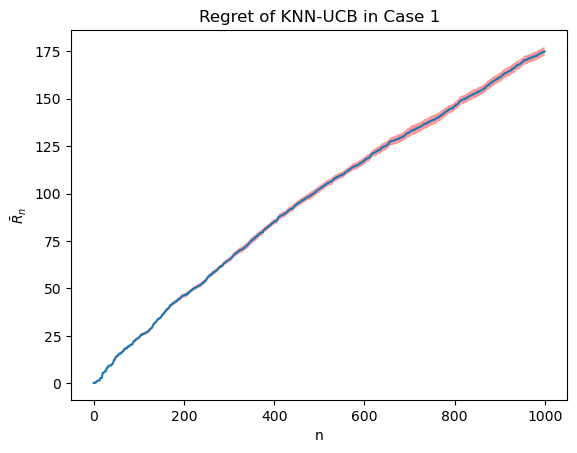

In [79]:
n = range(1000)
n_trials = 20
mean_regret = np.mean(regrets, axis = 0)
stds = np.std(regrets, axis = 0)
plt.xlabel('n')
plt.title('Regret of KNN-UCB in Case 1')
plt.ylabel("$\\bar{R}_n$")
upper_ci = mean_regret + (1.96*np.array(stds))/np.sqrt(n_trials)
lower_ci = mean_regret - (1.96*np.array(stds))/np.sqrt(n_trials)
plt.fill_between(n,lower_ci,upper_ci,facecolor='red', alpha=0.4)
plt.plot(n,mean_regret)

In [82]:
X = np.random.uniform(0,1, size = (2000,2))
rewards0 = [lambdas[0](x) for x in X]
rewards1 = [lambdas[1](x) for x in X ]

In [83]:
maxli = 0
for j, x1 in enumerate(X):
    if(j%100 == 0):
        print(j)
    for k, x2 in enumerate(X):
        if sum(x2 != x1) == 0:
            pass
        else:
            maxli = max(abs(rewards0[j] - rewards0[k])/cdist([x1],[x2], 'Euclidean')[0][0], maxli)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [85]:
maxli - 4*m.pi

-0.069515315165388

In [54]:
lambdas = [lambda x: np.prod([m.sin(4*xs * m.pi) for xs in x]),
           lambda x: np.prod([m.cos(7*xs * m.pi) for xs in x])]
noise = lambda x : np.random.normal(0,0.5)
bandit = cb.ContextBandit(lambdas, noise)
bandit.pull(0,[0.4,0.3])

-0.14193389967921277

In [64]:
np.savetxt('regrets.csv', np.asarray(np.random.normal(0,1,size = (2,5,2))), delimiter=',')

ValueError: Expected 1D or 2D array, got 3D array instead